# Vanguard A/B Test – EDA & Data Cleaning

## Context
This notebook focuses on the exploratory data analysis (EDA) and data cleaning of Vanguard’s digital A/B test. The objective is to understand client profiles, digital behavior, and data quality before evaluating the experiment results.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [1]:
DATA_PATH = "../data"
DATA_PATH


'../data'

In [7]:
demo = pd.read_csv(f"{DATA_PATH}/df_final_demo.txt")
experiment = pd.read_csv(f"{DATA_PATH}/df_final_experiment_clients.txt")
web_pt1 = pd.read_csv(f"{DATA_PATH}/df_final_web_data_pt_1.txt")
web_pt2 = pd.read_csv(f"{DATA_PATH}/df_final_web_data_pt_2.txt")

print(
    demo.head(),
    experiment.head(),
    web_pt1.head(),
    web_pt2.head()
)

   client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0     836976             6.0              73.0      60.5     U        2.0   
1    2304905             7.0              94.0      58.0     U        2.0   
2    1439522             5.0              64.0      32.0     U        2.0   
3    1562045            16.0             198.0      49.0     M        2.0   
4    5126305            12.0             145.0      33.0     F        2.0   

         bal  calls_6_mnth  logons_6_mnth  
0   45105.30           6.0            9.0  
1  110860.30           6.0            9.0  
2   52467.79           6.0            9.0  
3   67454.65           3.0            6.0  
4  103671.75           0.0            3.0      client_id Variation
0    9988021      Test
1    8320017      Test
2    4033851   Control
3    1982004      Test
4    9294070   Control    client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453

In [8]:
print(
    demo.shape,
    experiment.shape,
    web_pt1.shape,
    web_pt2.shape
)

(70609, 9) (70609, 2) (343141, 5) (412264, 5)


In [10]:
web = pd.concat([web_pt1, web_pt2], axis=0)
web.shape
web.head()


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [11]:
web['date_time'] = pd.to_datetime(web['date_time'])
web['date_time'].min(), web['date_time'].max()


(Timestamp('2017-03-15 00:03:03'), Timestamp('2017-06-20 23:59:57'))

In [14]:
df = (
    web
    .merge(experiment, on='client_id', how='inner')
    .merge(demo, on='client_id', how='left')
)
print(df.shape)
df.head()

(449831, 14)


,client_id,visitor_id,visit_id,process_step,date_time,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0


In [20]:
df['process_step'].value_counts()
#la mayor caída es de start → step_1
#el proceso va perdiendo usuarios paso a paso
#60k usuarios completan el proceso (40% del total)

process_step
start      145588
step_1      95896
step_2      79571
step_3      68217
confirm     60559
Name: count, dtype: int64

In [22]:
funnel = (
    df.groupby(['Variation', 'process_step'])['client_id']
    .nunique()
    .reset_index(name='users')
)

funnel


,Variation,process_step,users
0,Control,confirm,15434
1,Control,start,23397
2,Control,step_1,20152
3,Control,step_2,18650
4,Control,step_3,17422
5,Test,confirm,18687
6,Test,start,26679
7,Test,step_1,24267
8,Test,step_2,22258
9,Test,step_3,20881


In [23]:
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

funnel['process_step'] = pd.Categorical(
    funnel['process_step'],
    categories=step_order,
    ordered=True
)

funnel = funnel.sort_values(['Variation', 'process_step'])
funnel


,Variation,process_step,users
1,Control,start,23397
2,Control,step_1,20152
3,Control,step_2,18650
4,Control,step_3,17422
0,Control,confirm,15434
6,Test,start,26679
7,Test,step_1,24267
8,Test,step_2,22258
9,Test,step_3,20881
5,Test,confirm,18687


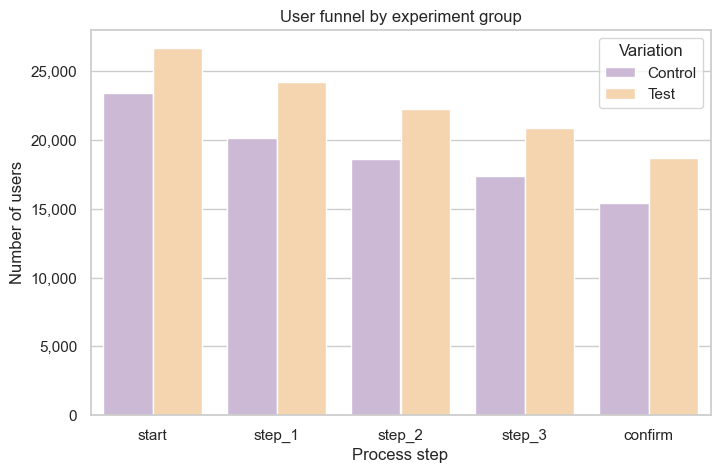

In [28]:
import matplotlib.ticker as mtick

plt.figure(figsize=(8,5))

sns.barplot(
    data=funnel,
    x='process_step',
    y='users',
    hue='Variation',
    palette={
        'Control': '#CDB4DB',  
        'Test': '#FFD6A5'      
    }
)

plt.title("User funnel by experiment group")
plt.xlabel("Process step")
plt.ylabel("Number of users")

# Add point to y-axis labels
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, p: format(int(x), ","))
)

plt.show()


In [29]:
#Clients demographics
df[['clnt_age', 'clnt_tenure_yr']].describe()


,clnt_age,clnt_tenure_yr
count,449704.000000,449716.000000
mean,47.653966,12.234130
std,15.742089,7.005183
min,13.500000,2.000000
25%,33.500000,6.000000
50%,49.000000,11.000000
75%,60.000000,16.000000
max,96.000000,62.000000


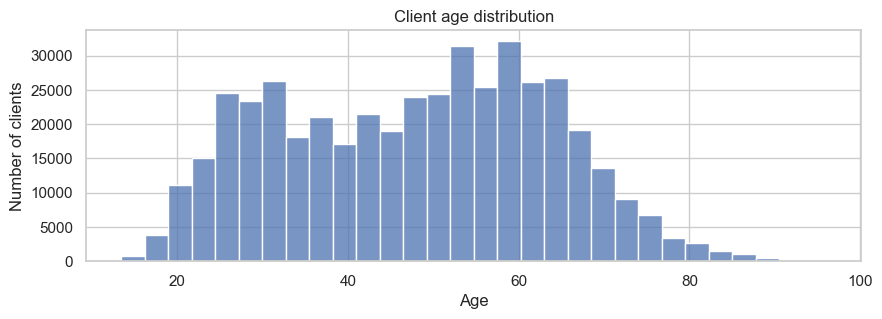

In [34]:
plt.figure(figsize=(10,3))
sns.histplot(df['clnt_age'], bins=30)
plt.title("Client age distribution")
plt.xlabel("Age")
plt.ylabel("Number of clients")
plt.show()


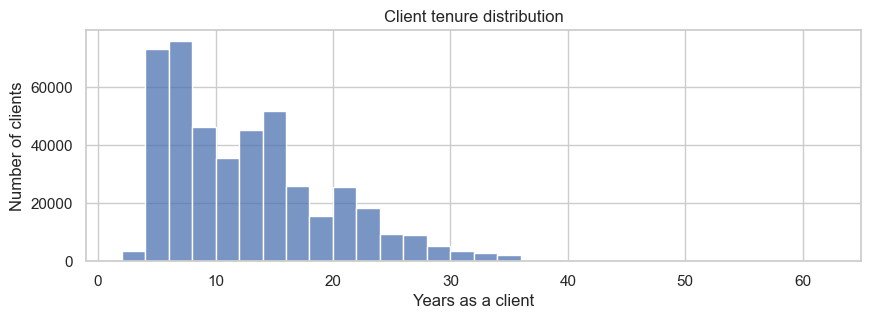

In [35]:
plt.figure(figsize=(10,3))
sns.histplot(df['clnt_tenure_yr'], bins=30)
plt.title("Client tenure distribution")
plt.xlabel("Years as a client")
plt.ylabel("Number of clients")
plt.show()


In [36]:
df.groupby('Variation')[['clnt_age', 'clnt_tenure_yr']].mean()


,clnt_age,clnt_tenure_yr
Variation,,
Control,48.309896,12.171803
Test,48.750018,12.180058


## Day 1–2 Objectives: Summary

**Dataset discovery**
- The structure, size, and key variables of all datasets were explored using Pandas.
- The relationship between client profiles, experiment assignment, and web interaction data was identified.
- Matplotlib and Seaborn were used for initial visual exploration.

**Data cleaning**
- Web interaction data from multiple files was merged into a single dataset.
- Timestamps were converted to datetime format and events were ordered chronologically.
- Digital process steps were validated and no critical data quality issues were detected.

**Client behaviour analysis**
- User behaviour follows a clear funnel structure from start to confirmation.
- Progressive drop-off is observed at each step of the digital process.
- The Test group consistently retains more users than the Control group across all steps.
- These findings provide a strong basis for defining KPIs and performing hypothesis testing in the next phase.

**Client demographics**
- The primary users of the online process are middle-aged clients.
- Most users are long-standing Vanguard clients rather than newly onboarded customers.
- Control and Test groups show very similar demographic profiles, indicating a well-balanced experiment.
